# Northing Calibration in FLASC

Northing calibration, that is the detection of bias and changes in measurements of turbine yaw are important for many of the analysis in FLASC.  This notebook demonstrates the use of several of these tools in FLASC for the calibration of northing measurements.

In [1]:
import warnings as wn
from datetime import timedelta as td

import numpy as np
import pandas as pd
from floris import TimeSeries
from floris.layout_visualization import plot_turbine_labels, plot_turbine_points
from floris.utilities import wrap_360
from matplotlib import pyplot as plt

from flasc import FlascDataFrame
from flasc.data_processing import (
    dataframe_manipulations as dfm,
    energy_ratio_wd_bias_estimation as best,
    filtering as filt,
    northing_offset as nof,
)
from flasc.data_processing.northing_offset_change_hoger import homogenize_hoger
from flasc.utilities import (
    floris_tools as ftools,
    optimization as flopt,
)
from flasc.utilities.utilities_examples import load_floris_artificial as load_floris

## Load FLORIS model and show layout

In [2]:
# Load FLORIS model
fm, turbine_weights = load_floris()

<Axes: >

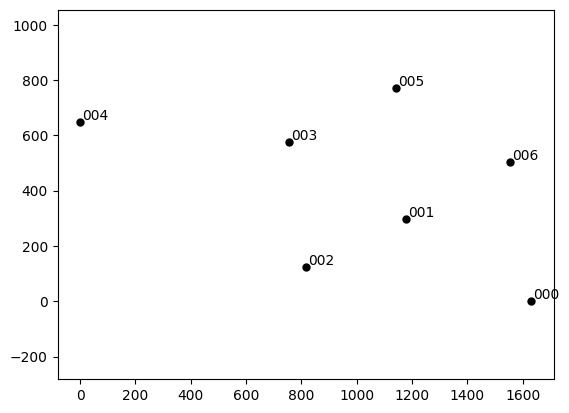

In [3]:
# Show the layout
fig, ax = plt.subplots()
plot_turbine_points(fm, ax)
plot_turbine_labels(fm, ax)

## Generate data set to illustrate operations

For simplicity assume a fixed wind speed and turbulence intensity and uniform wind direction.  Perturb the wind direction by random noise

In [4]:
# Set wind direction to step from 90 to 270, in steps that are 600 long and 10 degrees wide

wind_directions = np.linspace(90, 270, 10)
wind_directions = np.tile(wind_directions, 600)
wind_directions = np.sort(wind_directions)

# Apply noise
np.random.seed(0)
noise = np.random.normal(0, 5.0, wind_directions.shape)
wind_directions = wind_directions + noise

# Set a FLORIS time series object
time_series = TimeSeries(
    wind_directions=wind_directions, wind_speeds=8.0, turbulence_intensities=0.06
)

In [5]:
# Calculate FLORIS solution
fm.set(wind_data=time_series)
fm.run()
turbine_powers = fm.get_turbine_powers()

# Add random noise to the power output
turbine_powers = turbine_powers + np.random.normal(0, 25.0, turbine_powers.shape)

In [6]:
# Use the results to create a FLASC dataframe representing hypothetical scada data
df_scada = FlascDataFrame(
    {
        "time": pd.date_range(start="1/1/2020", periods=len(wind_directions), freq="600s"),
        "wind_directions": wind_directions,
        "wind_speeds": 8.0 * np.ones_like(wind_directions),
        "ti": 0.06 * np.ones_like(wind_directions),
    }
)

In [7]:
# Add the turbine powers to the dataframe with some added noise
for t_idx in range(fm.n_turbines):
    df_scada[f"pow_{t_idx:03d}"] = turbine_powers[:, t_idx]

# Set the turbine wind directions to be the true wind direction with some added noise
for t_idx in range(fm.n_turbines):
    df_scada[f"wd_{t_idx:03d}"] = wrap_360(
        wind_directions + np.random.normal(0, 5.0, wind_directions.shape)
    )

# Set wind speeds to be fixed with small noise
for t_idx in range(fm.n_turbines):
    df_scada[f"ws_{t_idx:03d}"] = 8.0 * np.ones_like(wind_directions) + np.random.normal(
        0, 0.1, wind_directions.shape
    )

df_scada

,time,wind_directions,wind_speeds,ti,pow_000,pow_001,pow_002,pow_003,pow_004,pow_005,...,wd_004,wd_005,wd_006,ws_000,ws_001,ws_002,ws_003,ws_004,ws_005,ws_006
0,2020-01-01 00:00:00,98.820262,8.0,0.06,1.754006e+06,1.753879e+06,6.357473e+05,9.640375e+05,9.666355e+05,1.753524e+06,...,99.644321,101.107205,99.348930,8.011852,8.162351,8.159744,7.899556,8.076833,8.185659,8.064289
1,2020-01-01 00:10:00,92.000786,8.0,0.06,1.753913e+06,1.753904e+06,1.409497e+06,8.553318e+05,9.171484e+05,1.753951e+06,...,82.166085,88.043464,89.257707,8.175628,7.808788,8.023940,8.084883,8.080681,7.849506,7.913113
2,2020-01-01 00:20:00,94.893690,8.0,0.06,1.753985e+06,1.753891e+06,9.842584e+05,6.162996e+05,6.600864e+05,1.753942e+06,...,94.712330,92.252229,90.985282,7.991109,7.892661,7.928803,8.081048,8.073745,8.091502,8.053268
3,2020-01-01 00:30:00,101.204466,8.0,0.06,1.753950e+06,1.753555e+06,8.123594e+05,1.319409e+06,1.170321e+06,1.751776e+06,...,110.699134,93.116417,108.537493,7.917771,8.077458,7.942418,7.960415,7.766181,7.875381,8.012211
4,2020-01-01 00:40:00,99.337790,8.0,0.06,1.754020e+06,1.753852e+06,6.487232e+05,1.043126e+06,1.030381e+06,1.753318e+06,...,95.656436,92.461185,106.783658,7.850214,7.973655,8.028457,8.225742,8.147089,7.934316,7.798261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,2020-02-11 15:10:00,263.345981,8.0,0.06,1.753204e+06,1.687681e+06,1.753965e+06,1.730570e+06,1.753947e+06,8.849585e+05,...,261.464863,265.654828,265.006674,7.867506,8.118957,7.879889,7.999180,8.046216,7.930540,7.880831
5996,2020-02-11 15:20:00,271.762993,8.0,0.06,1.435174e+06,1.752561e+06,1.753922e+06,9.033320e+05,1.753985e+06,1.702120e+06,...,271.559170,267.387924,271.051594,8.028336,8.219887,7.878284,8.086875,8.154903,8.149477,8.080819
5997,2020-02-11 15:30:00,267.310576,8.0,0.06,1.728385e+06,1.740995e+06,1.753938e+06,1.521491e+06,1.753960e+06,1.223109e+06,...,267.398639,263.998493,270.306531,8.020642,8.044316,8.031791,8.170447,8.253171,8.056111,7.903335
5998,2020-02-11 15:40:00,271.967222,8.0,0.06,1.408887e+06,1.752647e+06,1.753962e+06,8.717409e+05,1.753956e+06,1.709693e+06,...,270.043104,273.116864,281.039771,8.063863,7.936743,8.230575,8.071727,7.996428,8.013610,8.109070


#### Northing calibration error

Add to the data two types of northing calibration error:
1. A constant bias on turbine 001
2. A change in bias on turbine 002 halfway through the data set

In [8]:
df_scada["wd_001"] = wrap_360(
    15.0 + wind_directions + np.random.normal(0, 0.5, wind_directions.shape)
)

mid_point = int(len(wind_directions) / 2)
wd_change = wind_directions + np.random.normal(0, 0.5, wind_directions.shape)
wd_change[mid_point:] = wd_change[mid_point:] - 45.0
wd_change = wrap_360(wd_change)
df_scada["wd_002"] = wd_change

Text(0, 0.5, 'Wind direction (deg)')

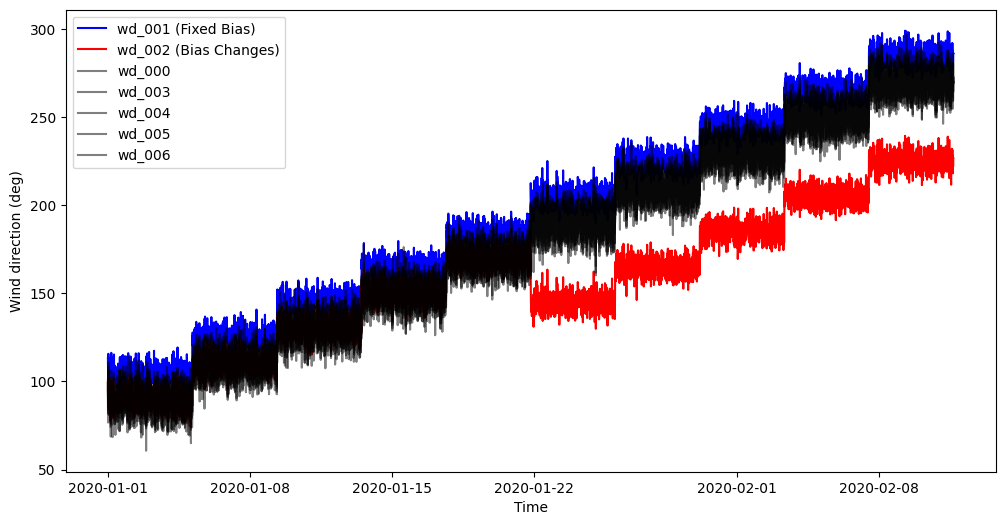

In [ ]:
# Show the wd channels for the turbines
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(df_scada["time"], df_scada["wd_001"], label="wd_001 (Fixed Bias)", color="blue")
ax.plot(df_scada["time"], df_scada["wd_002"], label="wd_002 (Bias Changes)", color="red")
ax.plot(df_scada["time"], df_scada["wd_000"], label="wd_000", color="k", alpha=0.5)
ax.plot(df_scada["time"], df_scada["wd_003"], label="wd_003", color="k", alpha=0.5)
ax.plot(df_scada["time"], df_scada["wd_004"], label="wd_004", color="k", alpha=0.5)
ax.plot(df_scada["time"], df_scada["wd_005"], label="wd_005", color="k", alpha=0.5)
ax.plot(df_scada["time"], df_scada["wd_006"], label="wd_006", color="k", alpha=0.5)
ax.legend()
ax.set_xlabel("Time")
ax.set_ylabel("Wind direction (deg)")

In [10]:
# Finally compute df_approx for use in later algorithms
# Can compute only at 8m/s for this example
df_fm_approx = ftools.calc_floris_approx_table(
    fm=fm,  # fi=fi_pci,
    wd_array=np.arange(0.0, 360.01, 1.0),
    ws_array=np.array([8.0]),
    ti_array=np.array([0.06]),
)

2024-12-02 11:23:06 Generating a df_approx table of FLORIS solutions covering a total of 361 cases.
2024-12-02 11:23:06 Finished calculating the FLORIS solutions for the dataframe.


# Cross-Check Northing calibration 

`crosscheck_northing_offset_consistency` is a function to check if the relative offset between turbines is consistent. If the offset is consistent, then we know we can find a single offset value that would align the two turbine's northings. If this is not the case, one or both turbines likely experience jumps in their nacelle calibration throughout the timeseries. 

2024-12-02 11:23:06 Matching curves for turbine 000...
2024-12-02 11:23:07     T006  T001  T002  T005  T003
0    0.0 -16.0   0.0   0.0   0.0
1    0.0 -14.0   0.0   0.0   0.0
2    0.0 -16.0   0.0   0.0   0.0
3    0.0 -16.0   0.0   0.0   0.0
4    0.0 -14.0   0.0   2.0   0.0
5    0.0 -14.0   0.0   0.0   0.0
6    0.0 -16.0   0.0   0.0  -2.0
7    0.0 -16.0   0.0   0.0   0.0
8    0.0 -16.0   0.0   0.0   0.0
9    0.0 -16.0   0.0   0.0   0.0
10   0.0 -16.0   0.0   0.0   0.0
11   0.0 -16.0   0.0   0.0   0.0
12   0.0 -14.0   0.0   0.0   0.0
13   0.0 -14.0   0.0   0.0   0.0
14  -2.0 -16.0   0.0   0.0   0.0
15   0.0 -14.0   0.0   0.0   0.0
16   2.0 -14.0   0.0   2.0   0.0
17   0.0 -14.0   0.0   0.0   0.0
18  -2.0 -16.0   0.0   0.0   0.0
19   0.0 -16.0   0.0   0.0   0.0
20   0.0 -14.0   8.0   0.0   2.0
21   0.0 -14.0  46.0   0.0   0.0
22   0.0 -14.0  46.0   0.0   0.0
23   0.0 -14.0  46.0   0.0   0.0
24   0.0 -14.0  46.0   2.0   0.0
25   0.0 -16.0  44.0   0.0   0.0
26   0.0 -16.0  44.0  -2.0   0.0
2

['clean', 'clean', 'bad', 'clean', 'clean', 'clean', 'clean']


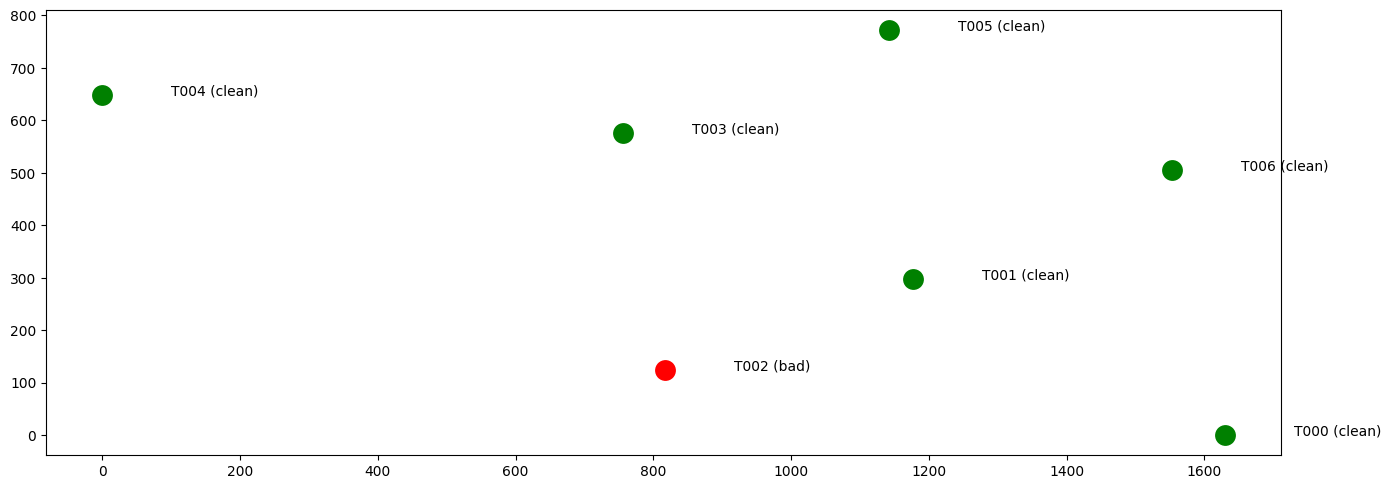

In [11]:
# Create a copy in which we mark the wd measurements of turbines with northing drift  as faulty
df_scada_marked_faulty_northing_drift = df_scada.copy()

turb_wd_consistency = nof.crosscheck_northing_offset_consistency(
    df=df_scada_marked_faulty_northing_drift, fm=fm, plot_figure=True, bias_timestep=td(days=1)
)
print(turb_wd_consistency)

`crosscheck_northing_offset_consistency` detects that T002 contains a probable jump, one solution is to then remove T002's wind direction data from consideration however this is not done in this notebook as we next take advantage of HOGER recalibration.  The code to do this is included below in comments

In [12]:
# # Mark wind direction measurements of turbines with inconsistent calibration as faulty
# faulty_turbines = [not s == "clean" for s in turb_wd_consistency]
# for ti in np.where(faulty_turbines)[0]:
#     df_scada_marked_faulty_northing_drift["wd_{:03d}".format(ti)] = np.nan

## Homegenization with HOGER

The `homogenize` function implements the HOGER method for recalibrating northing measurements. HOGER was developed by Paul Poncet (https://github.com/engie-paul-poncet)
 and Thomas Duc (https://github.com/engie-thomas-duc) of Engie, and Rubén González-Lope (https://github.com/rglope) and Alvaro Gonzalez Salcedo (https://github.com/alvarogonzalezsalcedo) of CENER within the TWAIN project.

 The `homogenize` will remove apparent jumps in northing correction (but does not confirm the final level is unbiased overall)

In [13]:
df_scada_non_homogenized = df_scada.copy()
df_scada_homogenized, d2 = homogenize_hoger(df_scada_marked_faulty_northing_drift, threshold=10)

# Show the search results
d2

[2999.5]


/Users/pfleming/Projects/FLASC/flasc/flasc/data_processing/northing_offset_change_hoger.py:110: UserWarning: Encountered a tie, and the difference between minimal and maximal value is > length('x') * 0.05.
 The distribution could be multimodal
  warnings.warn(


,Class,Turbine,Count,Jump,Knot,Knot_date
0,1,wd_002,6,44.982446,2999.5,2020-01-21 19:40:00


The HOGER homeginization removes changes in northing calibration of turbines with respect to others, however the final selected value may contain a steady offset, as happens in this case

Text(0, 0.5, 'Wind direction (deg)')

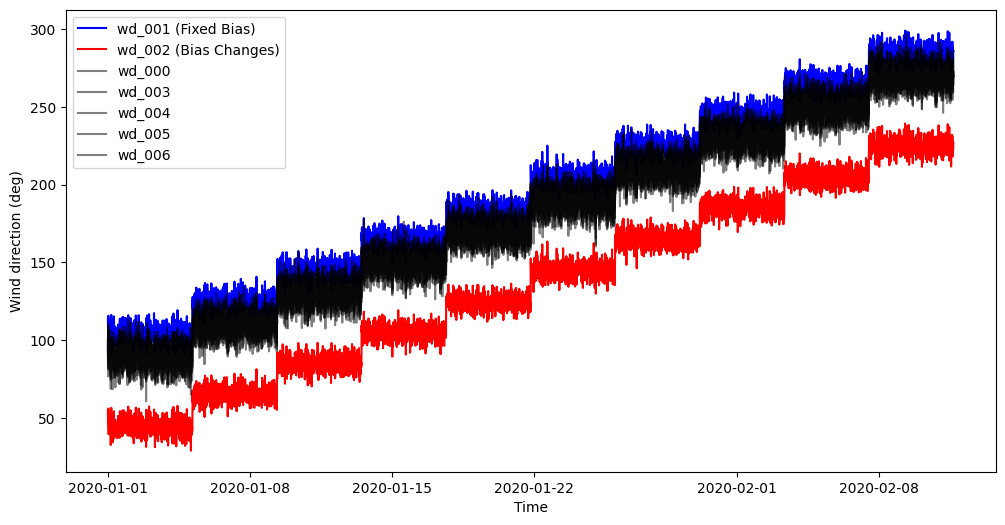

In [ ]:
# Show the effects of homogenization
# Show the wd channels for the turbines
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(
    df_scada_homogenized["time"],
    df_scada_homogenized["wd_001"],
    label="wd_001 (Fixed Bias)",
    color="blue",
)
ax.plot(
    df_scada_homogenized["time"],
    df_scada_homogenized["wd_002"],
    label="wd_002 (Bias Changes)",
    color="red",
)
ax.plot(
    df_scada_homogenized["time"],
    df_scada_homogenized["wd_000"],
    label="wd_000",
    color="k",
    alpha=0.5,
)
ax.plot(
    df_scada_homogenized["time"],
    df_scada_homogenized["wd_003"],
    label="wd_003",
    color="k",
    alpha=0.5,
)
ax.plot(
    df_scada_homogenized["time"],
    df_scada_homogenized["wd_004"],
    label="wd_004",
    color="k",
    alpha=0.5,
)
ax.plot(
    df_scada_homogenized["time"],
    df_scada_homogenized["wd_005"],
    label="wd_005",
    color="k",
    alpha=0.5,
)
ax.plot(
    df_scada_homogenized["time"],
    df_scada_homogenized["wd_006"],
    label="wd_006",
    color="k",
    alpha=0.5,
)
ax.legend()
ax.set_xlabel("Time")
ax.set_ylabel("Wind direction (deg)")

# Recalculate which turbines are clean with respect to offset changes

2024-12-02 11:23:09 Matching curves for turbine 000...
2024-12-02 11:23:10     T006  T001  T002  T005  T003
0    0.0 -16.0  44.0   0.0   0.0
1    0.0 -16.0  44.0   0.0   0.0
2    0.0 -14.0  46.0   0.0   0.0
3    0.0 -16.0  44.0   0.0   0.0
4    0.0 -16.0  44.0   0.0   0.0
5    0.0 -16.0  44.0   0.0   0.0
6    0.0 -14.0  46.0   0.0   0.0
7    0.0 -16.0  44.0   0.0   0.0
8    0.0 -14.0  46.0   0.0   0.0
9    0.0 -16.0  44.0   0.0   0.0
10   0.0 -14.0  46.0   0.0   0.0
11   0.0 -14.0  46.0   0.0   0.0
12   0.0 -14.0  44.0   0.0   0.0
13   0.0 -14.0  46.0   0.0   0.0
14   0.0 -14.0  46.0   0.0   0.0
15   0.0 -16.0  44.0   0.0   0.0
16   0.0 -16.0  44.0   0.0   0.0
17   0.0 -14.0  46.0   0.0   0.0
18   0.0 -14.0  46.0   0.0   0.0
19   0.0 -14.0  46.0   0.0   0.0
20   0.0 -14.0  46.0   0.0   0.0
2024-12-02 11:23:10 Matching curves for turbine 001...
2024-12-02 11:23:10     T002  T006  T005  T003  T000
0   60.0  16.0  14.0  16.0  16.0
1   60.0  16.0  14.0  14.0  16.0
2   60.0  14.0  16.0  16.

['clean', 'clean', 'clean', 'clean', 'clean', 'clean', 'clean']


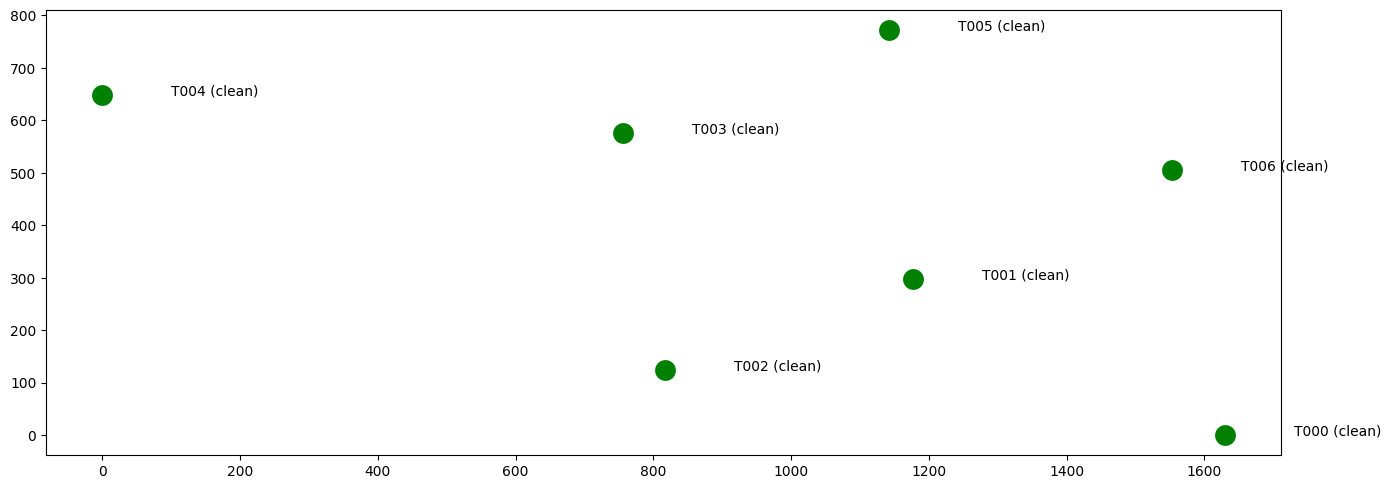

In [15]:
# Create a copy in which we mark the wd measurements of turbines with northing drift  as faulty
df_scada_marked_faulty_northing_drift = df_scada_homogenized.copy()

turb_wd_consistency = nof.crosscheck_northing_offset_consistency(
    df=df_scada_marked_faulty_northing_drift, fm=fm, plot_figure=True, bias_timestep=td(days=2)
)
print(turb_wd_consistency)

# Remove steady offset from a single turbine
By looking at the energy ratios and looking at the average offset between turbines' wind direction measurements, we can align every turbine that was flagged 'green' in the above plot with true north. Wind directions of turbines flagged red should not be used.

2024-12-02 11:23:11 Initializing a bias_estimation() object...
2024-12-02 11:23:11 Estimating the wind direction bias
2024-12-02 11:23:11     Initializing energy ratio inputs.
2024-12-02 11:23:11   Constructing energy table for wd_bias of -180.00 deg.
2024-12-02 11:23:11     Interpolating FLORIS predictions for dataframe.
2024-12-02 11:23:11 Warning: the values in df[ws] exceed the range in the precalculated solutions df_fi_approx[ws].
2024-12-02 11:23:11    minimum/maximum value in df:        (7.798, 8.248)
2024-12-02 11:23:11    minimum/maximum value in df:        (7.798, 8.248)
2024-12-02 11:23:11    minimum/maximum value in df_approx: (8.000, 8.000)


Initializing wd bias estimator object for turbine 000...


2024-12-02 11:23:11     Determining energy ratios for test turbine = 006. WD bias: -180.000 deg.
2024-12-02 11:23:11     Determining energy ratios for test turbine = 001. WD bias: -180.000 deg.
2024-12-02 11:23:11     Determining energy ratios for test turbine = 002. WD bias: -180.000 deg.
2024-12-02 11:23:11     Initializing energy ratio inputs.
2024-12-02 11:23:11   Constructing energy table for wd_bias of -175.00 deg.
2024-12-02 11:23:11     Interpolating FLORIS predictions for dataframe.
2024-12-02 11:23:11 Warning: the values in df[ws] exceed the range in the precalculated solutions df_fi_approx[ws].
2024-12-02 11:23:11    minimum/maximum value in df:        (7.709, 8.248)
2024-12-02 11:23:11    minimum/maximum value in df:        (7.709, 8.248)
2024-12-02 11:23:11    minimum/maximum value in df_approx: (8.000, 8.000)
2024-12-02 11:23:11     Determining energy ratios for test turbine = 006. WD bias: -175.000 deg.
2024-12-02 11:23:11     Determining energy ratios for test turbine =

Optimization terminated successfully.
         Current function value: -0.893931
         Iterations: 1
         Function evaluations: 2
Turbine 0. estimated bias = 0.00025 deg.


2024-12-02 11:23:28     Interpolating FLORIS predictions for dataframe.
2024-12-02 11:23:28 Warning: the values in df[ws] exceed the range in the precalculated solutions df_fi_approx[ws].
2024-12-02 11:23:28    minimum/maximum value in df:        (7.776, 8.231)
2024-12-02 11:23:28    minimum/maximum value in df:        (7.776, 8.231)
2024-12-02 11:23:28    minimum/maximum value in df_approx: (8.000, 8.000)
2024-12-02 11:23:28     Determining energy ratios for test turbine = 006. WD bias: 0.000 deg.
2024-12-02 11:23:28     Determining energy ratios for test turbine = 001. WD bias: 0.000 deg.
2024-12-02 11:23:28     Determining energy ratios for test turbine = 002. WD bias: 0.000 deg.


WD bias for first clean turbine: 0.000 deg


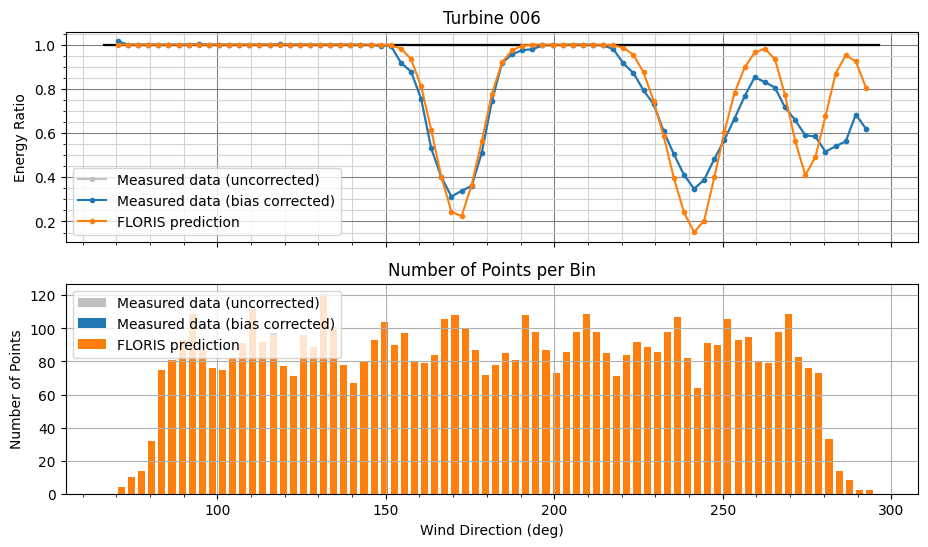

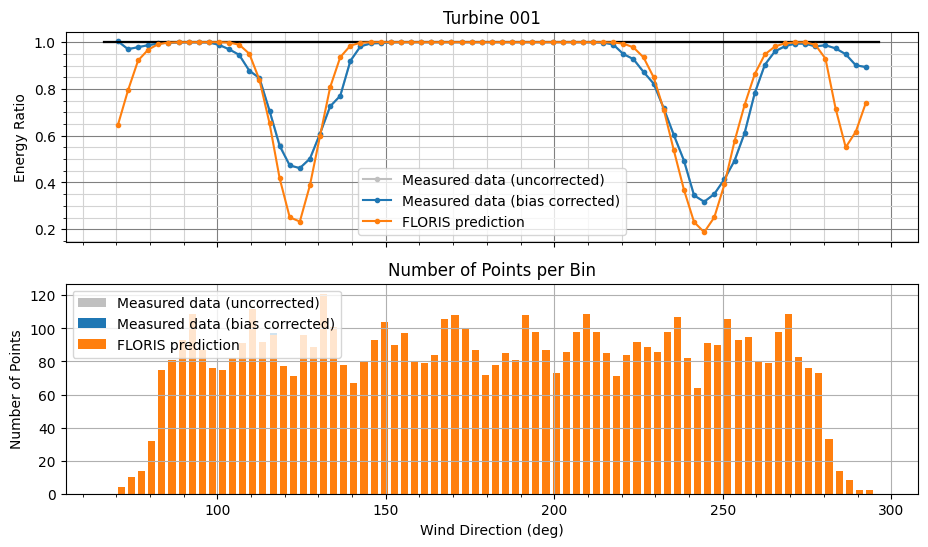

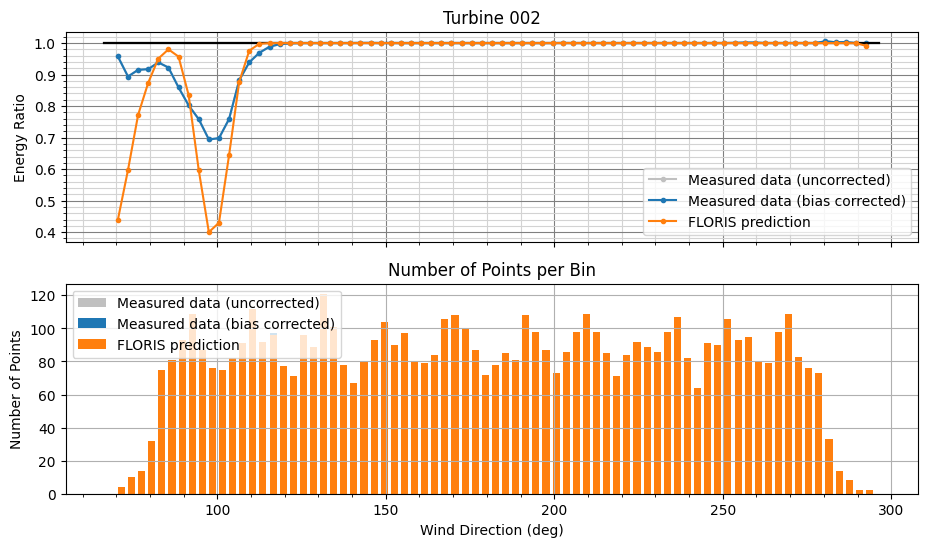

In [16]:
def get_bias_for_single_turbine(
    df, fm, ti, opt_search_range=[-180.0, 180.0], plot=True, figure_save_path=None
):
    print("Initializing wd bias estimator object for turbine %03d..." % ti)

    # Copy variables and unlink them
    df = df.copy()  # Unlink from input

    # Calculate which turbines are upstream for every wind direction
    df_upstream = ftools.get_upstream_turbs_floris(fm, wd_step=2.0)

    # We assign the total datasets "true" wind direction as equal to the wind
    # direction of the turbine which we want to perform northing calibration
    # on. In this case, turbine 'ti'.
    df = dfm.set_wd_by_turbines(df, [ti])

    # We define a function that calculates the freestream wind speed based
    # on a dataframe that is inserted. It does this based on knowing which
    # turbines are upstream for what wind directions, and then knowledge
    # of what the wind direction is for every row in the dataframe. However,
    # since the shift the "true" wind direction many times to estimate the
    # northing bias, we cannot precalculate this. It changes with every
    # northing bias guess. Hence, we must insert a function.
    def _set_ws_fun(df):
        return dfm.set_ws_by_upstream_turbines_in_radius(
            df=df,
            df_upstream=df_upstream,
            turb_no=ti,
            x_turbs=fm.layout_x,
            y_turbs=fm.layout_y,
            max_radius=5000.0,
            include_itself=True,
        )

    # We similarly define a function that calculates the reference power. This
    # is typically the power production of one or multiple upstream turbines.
    # Here, we assume it is the average power production of all upstream
    # turbines. Which turbines are upstream depends on the wind direction.
    def _set_pow_ref_fun(df):
        return dfm.set_pow_ref_by_upstream_turbines_in_radius(
            df=df,
            df_upstream=df_upstream,
            turb_no=ti,
            x_turbs=fm.layout_x,
            y_turbs=fm.layout_y,
            max_radius=5000.0,
            include_itself=True,
        )

    # We now have the reference power productions specified, being equal to
    # the mean power production of all turbines upstream. We also need to
    # define a test power production, which should be waked at least part of
    # the time so that we can match it with our FLORIS predictions. Here, we
    # calculate the energy ratios for the 3 turbines closest to the turbine
    # from which we take the wind direction measurement ('ti').
    turbines_sorted_by_distance = ftools.get_turbs_in_radius(
        x_turbs=fm.layout_x,
        y_turbs=fm.layout_y,
        turb_no=ti,
        max_radius=1.0e9,
        include_itself=False,
        sort_by_distance=True,
    )
    test_turbines = turbines_sorted_by_distance[0:3]

    # Now, we have all information set up and we can initialize the northing
    # bias estimation class.
    fsc = best.bias_estimation(
        df=df,
        df_fm_approx=df_fm_approx,
        test_turbines_subset=test_turbines,
        df_ws_mapping_func=_set_ws_fun,
        df_pow_ref_mapping_func=_set_pow_ref_fun,
    )

    # We can save the energy ratio curves for every iteration in the
    # optimization process. This is useful for debugging. However, it also
    # significantly slows down the estimation process. We disable it by
    # default by assigning it 'None'.
    plot_iter_path = None  # Disabled, useful for debugging but slow
    # plot_iter_path = os.path.join(out_path, "opt_iters_ti%03d" % ti)

    # Now estimate the wind direction bias while catching warning messages
    # that do not really inform but do pollute the console.
    with wn.catch_warnings():
        wn.filterwarnings(action="ignore", message="All-NaN slice encountered")

        # Estimate bias for the entire time range, from start to end of
        # dataframe, for wind speeds in region II of turbine operation, with
        # in steps of 3.0 deg (wd) and 5.0 m/s (ws). We search over the entire
        # range from -180.0 deg to +180.0 deg, in steps of 5.0 deg. This has
        # appeared to be a good stepsize empirically.
        wd_bias, _ = fsc.estimate_wd_bias(
            time_mask=None,  # For entire dataset
            ws_mask=(6.0, 10.0),
            er_wd_step=3.0,
            er_ws_step=5.0,
            er_wd_bin_width=3.0,
            er_N_btstrp=1,
            opt_search_brute_dx=5.0,
            opt_search_range=opt_search_range,
            plot_iter_path=plot_iter_path,
        )
        wd_bias = float(wd_bias[0])  # Convert to float

    # Print progress to console
    print("Turbine {}. estimated bias = {} deg.".format(ti, wd_bias))

    if plot:
        # Produce and save calibrated/corrected energy ratio figures
        fsc.plot_energy_ratios(show_uncorrected_data=True, save_path=figure_save_path)
        if figure_save_path is not None:
            print("Calibrated energy ratio figures saved to {:s}.".format(figure_save_path))

    # Finally, return the estimated wind direction bias
    return wd_bias


# We will calibrate the turbine nacelle heading for the first 'clean' turbine
first_clean_turbid = np.where([c == "clean" for c in turb_wd_consistency])[0][0]

# Calculate optimal bias for the first clean turbine, covering all possibilities
#  (from -180 deg to +180 deg offset)
wd_bias = get_bias_for_single_turbine(
    df=df_scada_homogenized,
    fm=fm,
    ti=first_clean_turbid,
    opt_search_range=(-180.0, 180.0),
    plot=True,
)
print("WD bias for first clean turbine: {:.3f} deg".format(wd_bias))

# Now calculate the northing-bias-corrected wind direction for this
#  turbine and call it our reference
wd_ref = wrap_360(df_scada_homogenized["wd_{:03d}".format(first_clean_turbid)] - wd_bias)

# **Step 4**: Estimate the biases of the remaining turbines
Now that we know the wind direction bias of a single turbine, we roughly know where true north lies. What we can now do is simply calculate the average offset between the wind direction of any turbine and this northing-calibrated wind direction. The wind direction bias for that turbine is likely very close to this number. We use this as a first guess for the energy-ratio-based bias estimation, and optimize within +- 5 degrees within this initial value.

2024-12-02 11:23:29 Initializing a bias_estimation() object...
2024-12-02 11:23:29 Estimating the wind direction bias
2024-12-02 11:23:29     Initializing energy ratio inputs.
2024-12-02 11:23:29   Constructing energy table for wd_bias of -5.00 deg.
2024-12-02 11:23:29     Interpolating FLORIS predictions for dataframe.
2024-12-02 11:23:29 Warning: the values in df[ws] exceed the range in the precalculated solutions df_fi_approx[ws].
2024-12-02 11:23:29    minimum/maximum value in df:        (7.776, 8.248)
2024-12-02 11:23:29    minimum/maximum value in df:        (7.776, 8.248)
2024-12-02 11:23:29    minimum/maximum value in df_approx: (8.000, 8.000)


Initializing wd bias estimator object for turbine 000...


2024-12-02 11:23:29     Determining energy ratios for test turbine = 006. WD bias: -5.000 deg.
2024-12-02 11:23:29     Determining energy ratios for test turbine = 001. WD bias: -5.000 deg.
2024-12-02 11:23:29     Determining energy ratios for test turbine = 002. WD bias: -5.000 deg.
2024-12-02 11:23:29     Initializing energy ratio inputs.
2024-12-02 11:23:29   Constructing energy table for wd_bias of 0.00 deg.
2024-12-02 11:23:29     Interpolating FLORIS predictions for dataframe.
2024-12-02 11:23:29 Warning: the values in df[ws] exceed the range in the precalculated solutions df_fi_approx[ws].
2024-12-02 11:23:29    minimum/maximum value in df:        (7.776, 8.231)
2024-12-02 11:23:29    minimum/maximum value in df:        (7.776, 8.231)
2024-12-02 11:23:29    minimum/maximum value in df_approx: (8.000, 8.000)
2024-12-02 11:23:29     Determining energy ratios for test turbine = 006. WD bias: 0.000 deg.
2024-12-02 11:23:29     Determining energy ratios for test turbine = 001. WD bia

Optimization terminated successfully.
         Current function value: -0.893931
         Iterations: 1
         Function evaluations: 2
Turbine 0. estimated bias = 0.00025 deg.


2024-12-02 11:23:30     Interpolating FLORIS predictions for dataframe.
2024-12-02 11:23:30 Warning: the values in df[ws] exceed the range in the precalculated solutions df_fi_approx[ws].
2024-12-02 11:23:30    minimum/maximum value in df:        (7.776, 8.231)
2024-12-02 11:23:30    minimum/maximum value in df:        (7.776, 8.231)
2024-12-02 11:23:30    minimum/maximum value in df_approx: (8.000, 8.000)
2024-12-02 11:23:30     Determining energy ratios for test turbine = 006. WD bias: 0.000 deg.
2024-12-02 11:23:30     Determining energy ratios for test turbine = 001. WD bias: 0.000 deg.
2024-12-02 11:23:30     Determining energy ratios for test turbine = 002. WD bias: 0.000 deg.
2024-12-02 11:23:31 Initializing a bias_estimation() object...
2024-12-02 11:23:31 Estimating the wind direction bias
2024-12-02 11:23:31     Initializing energy ratio inputs.
2024-12-02 11:23:31   Constructing energy table for wd_bias of 9.00 deg.
2024-12-02 11:23:31     Interpolating FLORIS predictions fo

 
Initializing wd bias estimator object for turbine 001...


2024-12-02 11:23:31     Determining energy ratios for test turbine = 006. WD bias: 9.000 deg.
2024-12-02 11:23:31     Determining energy ratios for test turbine = 005. WD bias: 9.000 deg.
2024-12-02 11:23:31     Initializing energy ratio inputs.
2024-12-02 11:23:31   Constructing energy table for wd_bias of 14.00 deg.
2024-12-02 11:23:31     Interpolating FLORIS predictions for dataframe.
2024-12-02 11:23:31 Warning: the values in df[ws] exceed the range in the precalculated solutions df_fi_approx[ws].
2024-12-02 11:23:31    minimum/maximum value in df:        (7.776, 8.231)
2024-12-02 11:23:31    minimum/maximum value in df:        (7.776, 8.231)
2024-12-02 11:23:31    minimum/maximum value in df_approx: (8.000, 8.000)
2024-12-02 11:23:31     Determining energy ratios for test turbine = 002. WD bias: 14.000 deg.
2024-12-02 11:23:31     Determining energy ratios for test turbine = 006. WD bias: 14.000 deg.
2024-12-02 11:23:31     Determining energy ratios for test turbine = 005. WD bia

Optimization terminated successfully.
         Current function value: -0.999869
         Iterations: 4
         Function evaluations: 8


2024-12-02 11:23:33     Determining energy ratios for test turbine = 005. WD bias: 14.963 deg.
2024-12-02 11:23:33     Initializing energy ratio inputs.
2024-12-02 11:23:33   Constructing energy table for wd_bias of 0.00 deg.
2024-12-02 11:23:33     Interpolating FLORIS predictions for dataframe.
2024-12-02 11:23:33 Warning: the values in df[ws] exceed the range in the precalculated solutions df_fi_approx[ws].
2024-12-02 11:23:33    minimum/maximum value in df:        (7.776, 8.253)
2024-12-02 11:23:33    minimum/maximum value in df:        (7.776, 8.253)
2024-12-02 11:23:33    minimum/maximum value in df_approx: (8.000, 8.000)
2024-12-02 11:23:33     Determining energy ratios for test turbine = 002. WD bias: 0.000 deg.
2024-12-02 11:23:33     Determining energy ratios for test turbine = 006. WD bias: 0.000 deg.
2024-12-02 11:23:33     Determining energy ratios for test turbine = 005. WD bias: 0.000 deg.


Turbine 1. estimated bias = 14.9625 deg.


2024-12-02 11:23:34 Initializing a bias_estimation() object...
2024-12-02 11:23:34 Estimating the wind direction bias
2024-12-02 11:23:34     Initializing energy ratio inputs.
2024-12-02 11:23:34   Constructing energy table for wd_bias of -49.00 deg.
2024-12-02 11:23:34     Interpolating FLORIS predictions for dataframe.
2024-12-02 11:23:34 Warning: the values in df[ws] exceed the range in the precalculated solutions df_fi_approx[ws].
2024-12-02 11:23:34    minimum/maximum value in df:        (7.776, 8.248)
2024-12-02 11:23:34    minimum/maximum value in df:        (7.776, 8.248)
2024-12-02 11:23:34    minimum/maximum value in df_approx: (8.000, 8.000)
2024-12-02 11:23:34     Determining energy ratios for test turbine = 001. WD bias: -49.000 deg.


 
Initializing wd bias estimator object for turbine 002...


2024-12-02 11:23:34     Determining energy ratios for test turbine = 003. WD bias: -49.000 deg.
2024-12-02 11:23:34     Determining energy ratios for test turbine = 005. WD bias: -49.000 deg.
2024-12-02 11:23:34     Initializing energy ratio inputs.
2024-12-02 11:23:34   Constructing energy table for wd_bias of -44.00 deg.
2024-12-02 11:23:34     Interpolating FLORIS predictions for dataframe.
2024-12-02 11:23:34 Warning: the values in df[ws] exceed the range in the precalculated solutions df_fi_approx[ws].
2024-12-02 11:23:34    minimum/maximum value in df:        (7.776, 8.231)
2024-12-02 11:23:34    minimum/maximum value in df:        (7.776, 8.231)
2024-12-02 11:23:34    minimum/maximum value in df_approx: (8.000, 8.000)
2024-12-02 11:23:34     Determining energy ratios for test turbine = 001. WD bias: -44.000 deg.
2024-12-02 11:23:34     Determining energy ratios for test turbine = 003. WD bias: -44.000 deg.
2024-12-02 11:23:34     Determining energy ratios for test turbine = 005.

Turbine 2. estimated bias = -44.962500000000006 deg.


2024-12-02 11:23:37 Initializing a bias_estimation() object...
2024-12-02 11:23:37 Estimating the wind direction bias
2024-12-02 11:23:37     Initializing energy ratio inputs.
2024-12-02 11:23:37   Constructing energy table for wd_bias of -5.00 deg.
2024-12-02 11:23:37     Interpolating FLORIS predictions for dataframe.
2024-12-02 11:23:37 Warning: the values in df[ws] exceed the range in the precalculated solutions df_fi_approx[ws].
2024-12-02 11:23:37    minimum/maximum value in df:        (7.776, 8.248)
2024-12-02 11:23:37    minimum/maximum value in df:        (7.776, 8.248)
2024-12-02 11:23:37    minimum/maximum value in df_approx: (8.000, 8.000)


 
Initializing wd bias estimator object for turbine 003...


2024-12-02 11:23:37     Determining energy ratios for test turbine = 005. WD bias: -5.000 deg.
2024-12-02 11:23:37     Determining energy ratios for test turbine = 002. WD bias: -5.000 deg.
2024-12-02 11:23:37     Determining energy ratios for test turbine = 001. WD bias: -5.000 deg.
2024-12-02 11:23:37     Initializing energy ratio inputs.
2024-12-02 11:23:37   Constructing energy table for wd_bias of 0.00 deg.
2024-12-02 11:23:37     Interpolating FLORIS predictions for dataframe.
2024-12-02 11:23:37 Warning: the values in df[ws] exceed the range in the precalculated solutions df_fi_approx[ws].
2024-12-02 11:23:37    minimum/maximum value in df:        (7.776, 8.248)
2024-12-02 11:23:37    minimum/maximum value in df:        (7.776, 8.248)
2024-12-02 11:23:37    minimum/maximum value in df_approx: (8.000, 8.000)
2024-12-02 11:23:38     Determining energy ratios for test turbine = 005. WD bias: 0.000 deg.
2024-12-02 11:23:38     Determining energy ratios for test turbine = 002. WD bia

Optimization terminated successfully.
         Current function value: -0.861142
         Iterations: 1
         Function evaluations: 2


2024-12-02 11:23:39     Initializing energy ratio inputs.
2024-12-02 11:23:39   Constructing energy table for wd_bias of 0.00 deg.
2024-12-02 11:23:39     Interpolating FLORIS predictions for dataframe.
2024-12-02 11:23:39 Warning: the values in df[ws] exceed the range in the precalculated solutions df_fi_approx[ws].
2024-12-02 11:23:39    minimum/maximum value in df:        (7.776, 8.248)
2024-12-02 11:23:39    minimum/maximum value in df:        (7.776, 8.248)
2024-12-02 11:23:39    minimum/maximum value in df_approx: (8.000, 8.000)
2024-12-02 11:23:39     Determining energy ratios for test turbine = 005. WD bias: 0.000 deg.
2024-12-02 11:23:39     Determining energy ratios for test turbine = 002. WD bias: 0.000 deg.
2024-12-02 11:23:39     Determining energy ratios for test turbine = 001. WD bias: 0.000 deg.


Turbine 3. estimated bias = 0.0 deg.


2024-12-02 11:23:39 Initializing a bias_estimation() object...
2024-12-02 11:23:39 Estimating the wind direction bias
2024-12-02 11:23:39     Initializing energy ratio inputs.
2024-12-02 11:23:39   Constructing energy table for wd_bias of -5.00 deg.
2024-12-02 11:23:39     Interpolating FLORIS predictions for dataframe.
2024-12-02 11:23:39 Warning: the values in df[ws] exceed the range in the precalculated solutions df_fi_approx[ws].
2024-12-02 11:23:39    minimum/maximum value in df:        (7.776, 8.231)
2024-12-02 11:23:39    minimum/maximum value in df:        (7.776, 8.231)
2024-12-02 11:23:39    minimum/maximum value in df_approx: (8.000, 8.000)
2024-12-02 11:23:39     Determining energy ratios for test turbine = 003. WD bias: -5.000 deg.


 
Initializing wd bias estimator object for turbine 004...


2024-12-02 11:23:39     Determining energy ratios for test turbine = 002. WD bias: -5.000 deg.
2024-12-02 11:23:39     Determining energy ratios for test turbine = 005. WD bias: -5.000 deg.
2024-12-02 11:23:39     Initializing energy ratio inputs.
2024-12-02 11:23:39   Constructing energy table for wd_bias of 0.00 deg.
2024-12-02 11:23:39     Interpolating FLORIS predictions for dataframe.
2024-12-02 11:23:39 Warning: the values in df[ws] exceed the range in the precalculated solutions df_fi_approx[ws].
2024-12-02 11:23:39    minimum/maximum value in df:        (7.776, 8.231)
2024-12-02 11:23:39    minimum/maximum value in df:        (7.776, 8.231)
2024-12-02 11:23:39    minimum/maximum value in df_approx: (8.000, 8.000)
2024-12-02 11:23:39     Determining energy ratios for test turbine = 003. WD bias: 0.000 deg.
2024-12-02 11:23:39     Determining energy ratios for test turbine = 002. WD bias: 0.000 deg.
2024-12-02 11:23:39     Determining energy ratios for test turbine = 005. WD bias

Optimization terminated successfully.
         Current function value: -0.890643
         Iterations: 1
         Function evaluations: 2


2024-12-02 11:23:40     Determining energy ratios for test turbine = 005. WD bias: 0.000 deg.
2024-12-02 11:23:40     Initializing energy ratio inputs.
2024-12-02 11:23:40   Constructing energy table for wd_bias of 0.00 deg.
2024-12-02 11:23:40     Interpolating FLORIS predictions for dataframe.
2024-12-02 11:23:40 Warning: the values in df[ws] exceed the range in the precalculated solutions df_fi_approx[ws].
2024-12-02 11:23:40    minimum/maximum value in df:        (7.776, 8.231)
2024-12-02 11:23:40    minimum/maximum value in df:        (7.776, 8.231)
2024-12-02 11:23:40    minimum/maximum value in df_approx: (8.000, 8.000)
2024-12-02 11:23:40     Determining energy ratios for test turbine = 003. WD bias: 0.000 deg.
2024-12-02 11:23:40     Determining energy ratios for test turbine = 002. WD bias: 0.000 deg.
2024-12-02 11:23:41     Determining energy ratios for test turbine = 005. WD bias: 0.000 deg.


Turbine 4. estimated bias = 0.0 deg.


2024-12-02 11:23:41 Initializing a bias_estimation() object...
2024-12-02 11:23:41 Estimating the wind direction bias
2024-12-02 11:23:41     Initializing energy ratio inputs.
2024-12-02 11:23:41   Constructing energy table for wd_bias of -5.00 deg.
2024-12-02 11:23:41     Interpolating FLORIS predictions for dataframe.
2024-12-02 11:23:41 Warning: the values in df[ws] exceed the range in the precalculated solutions df_fi_approx[ws].
2024-12-02 11:23:41    minimum/maximum value in df:        (7.776, 8.253)
2024-12-02 11:23:41    minimum/maximum value in df:        (7.776, 8.253)
2024-12-02 11:23:41    minimum/maximum value in df_approx: (8.000, 8.000)
2024-12-02 11:23:41     Determining energy ratios for test turbine = 003. WD bias: -5.000 deg.
2024-12-02 11:23:41     Determining energy ratios for test turbine = 001. WD bias: -5.000 deg.


 
Initializing wd bias estimator object for turbine 005...


2024-12-02 11:23:41     Determining energy ratios for test turbine = 006. WD bias: -5.000 deg.
2024-12-02 11:23:41     Initializing energy ratio inputs.
2024-12-02 11:23:41   Constructing energy table for wd_bias of 0.00 deg.
2024-12-02 11:23:41     Interpolating FLORIS predictions for dataframe.
2024-12-02 11:23:41 Warning: the values in df[ws] exceed the range in the precalculated solutions df_fi_approx[ws].
2024-12-02 11:23:41    minimum/maximum value in df:        (7.776, 8.248)
2024-12-02 11:23:41    minimum/maximum value in df:        (7.776, 8.248)
2024-12-02 11:23:41    minimum/maximum value in df_approx: (8.000, 8.000)
2024-12-02 11:23:41     Determining energy ratios for test turbine = 003. WD bias: 0.000 deg.
2024-12-02 11:23:41     Determining energy ratios for test turbine = 001. WD bias: 0.000 deg.
2024-12-02 11:23:41     Determining energy ratios for test turbine = 006. WD bias: 0.000 deg.
2024-12-02 11:23:41     Initializing energy ratio inputs.
2024-12-02 11:23:41   Co

Optimization terminated successfully.
         Current function value: -0.900444
         Iterations: 1
         Function evaluations: 2


2024-12-02 11:23:42     Initializing energy ratio inputs.
2024-12-02 11:23:42   Constructing energy table for wd_bias of 0.00 deg.
2024-12-02 11:23:42     Interpolating FLORIS predictions for dataframe.
2024-12-02 11:23:42 Warning: the values in df[ws] exceed the range in the precalculated solutions df_fi_approx[ws].
2024-12-02 11:23:42    minimum/maximum value in df:        (7.776, 8.248)
2024-12-02 11:23:42    minimum/maximum value in df:        (7.776, 8.248)
2024-12-02 11:23:42    minimum/maximum value in df_approx: (8.000, 8.000)
2024-12-02 11:23:42     Determining energy ratios for test turbine = 003. WD bias: 0.000 deg.
2024-12-02 11:23:42     Determining energy ratios for test turbine = 001. WD bias: 0.000 deg.
2024-12-02 11:23:42     Determining energy ratios for test turbine = 006. WD bias: 0.000 deg.


Turbine 5. estimated bias = 0.0 deg.


2024-12-02 11:23:43 Initializing a bias_estimation() object...
2024-12-02 11:23:43 Estimating the wind direction bias
2024-12-02 11:23:43     Initializing energy ratio inputs.
2024-12-02 11:23:43   Constructing energy table for wd_bias of -5.00 deg.
2024-12-02 11:23:43     Interpolating FLORIS predictions for dataframe.
2024-12-02 11:23:43 Warning: the values in df[ws] exceed the range in the precalculated solutions df_fi_approx[ws].
2024-12-02 11:23:43    minimum/maximum value in df:        (7.776, 8.248)
2024-12-02 11:23:43    minimum/maximum value in df:        (7.776, 8.248)
2024-12-02 11:23:43    minimum/maximum value in df_approx: (8.000, 8.000)
2024-12-02 11:23:43     Determining energy ratios for test turbine = 001. WD bias: -5.000 deg.


 
Initializing wd bias estimator object for turbine 006...


2024-12-02 11:23:43     Determining energy ratios for test turbine = 005. WD bias: -5.000 deg.
2024-12-02 11:23:43     Determining energy ratios for test turbine = 000. WD bias: -5.000 deg.
2024-12-02 11:23:43     Initializing energy ratio inputs.
2024-12-02 11:23:43   Constructing energy table for wd_bias of 0.00 deg.
2024-12-02 11:23:43     Interpolating FLORIS predictions for dataframe.
2024-12-02 11:23:43 Warning: the values in df[ws] exceed the range in the precalculated solutions df_fi_approx[ws].
2024-12-02 11:23:43    minimum/maximum value in df:        (7.776, 8.248)
2024-12-02 11:23:43    minimum/maximum value in df:        (7.776, 8.248)
2024-12-02 11:23:43    minimum/maximum value in df_approx: (8.000, 8.000)
2024-12-02 11:23:43     Determining energy ratios for test turbine = 001. WD bias: 0.000 deg.
2024-12-02 11:23:43     Determining energy ratios for test turbine = 005. WD bias: 0.000 deg.
2024-12-02 11:23:43     Determining energy ratios for test turbine = 000. WD bias

Optimization terminated successfully.
         Current function value: -0.884975
         Iterations: 1
         Function evaluations: 2


2024-12-02 11:23:44     Initializing energy ratio inputs.
2024-12-02 11:23:44   Constructing energy table for wd_bias of 0.00 deg.
2024-12-02 11:23:44     Interpolating FLORIS predictions for dataframe.
2024-12-02 11:23:44 Warning: the values in df[ws] exceed the range in the precalculated solutions df_fi_approx[ws].
2024-12-02 11:23:44    minimum/maximum value in df:        (7.776, 8.248)
2024-12-02 11:23:44    minimum/maximum value in df:        (7.776, 8.248)
2024-12-02 11:23:44    minimum/maximum value in df_approx: (8.000, 8.000)
2024-12-02 11:23:44     Determining energy ratios for test turbine = 001. WD bias: 0.000 deg.
2024-12-02 11:23:44     Determining energy ratios for test turbine = 005. WD bias: 0.000 deg.
2024-12-02 11:23:44     Determining energy ratios for test turbine = 000. WD bias: 0.000 deg.


Turbine 6. estimated bias = 0.00025 deg.
 
Wind direction biases: [ 2.50000e-04  1.49625e+01 -4.49625e+01  0.00000e+00  0.00000e+00
  0.00000e+00  2.50000e-04]


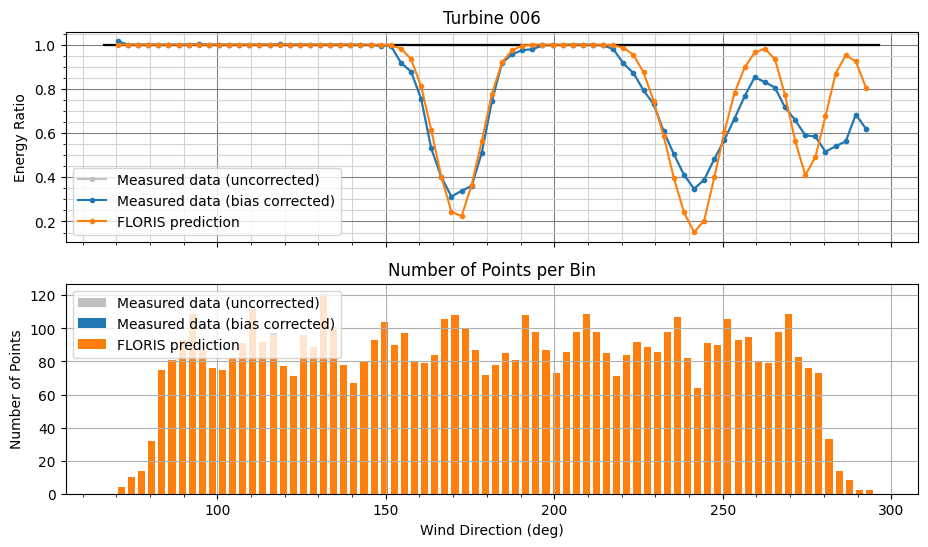

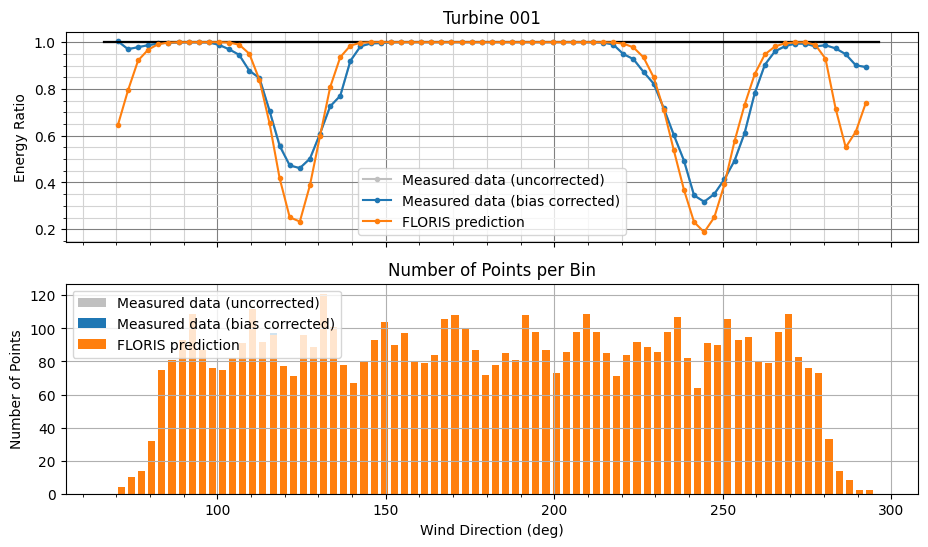

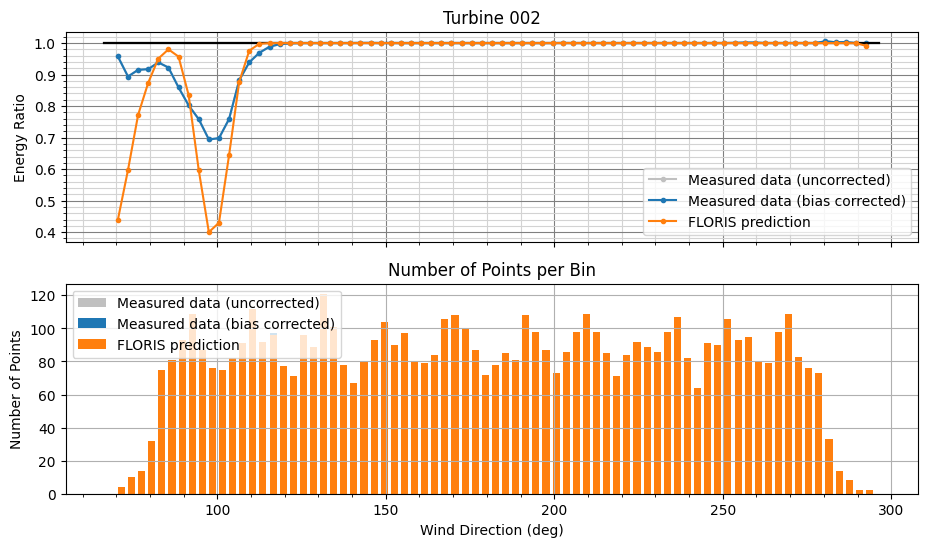

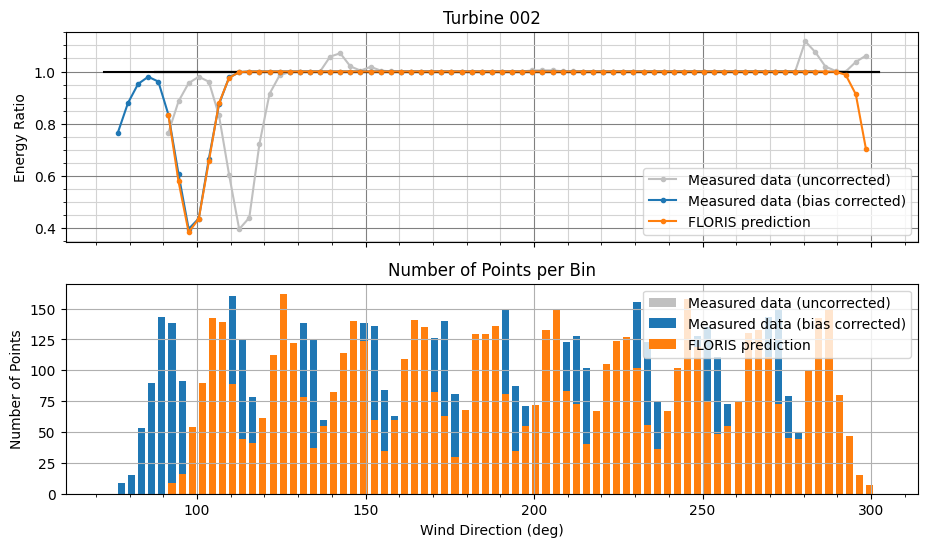

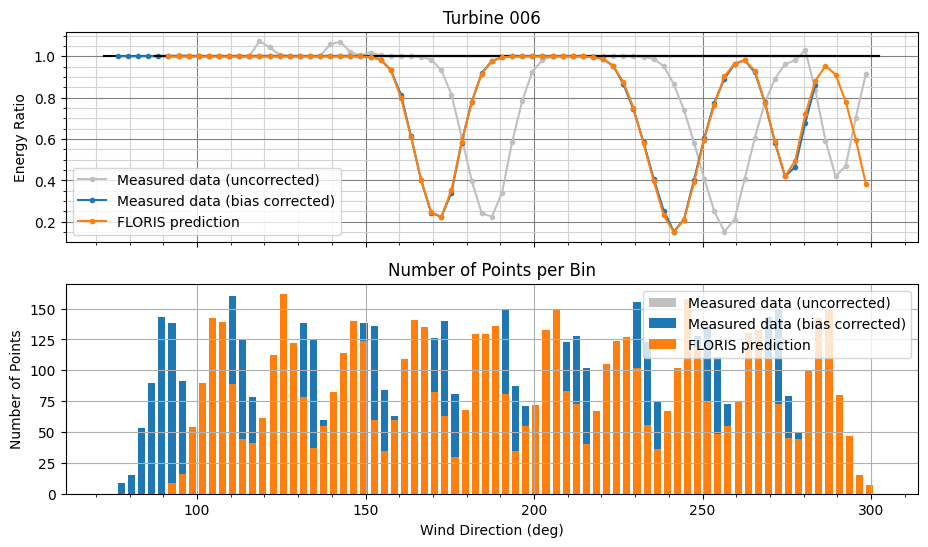

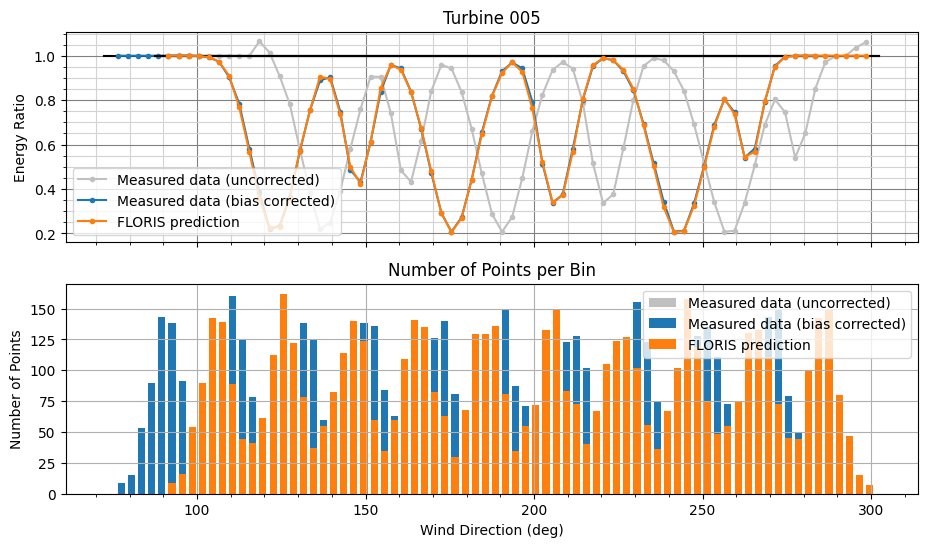

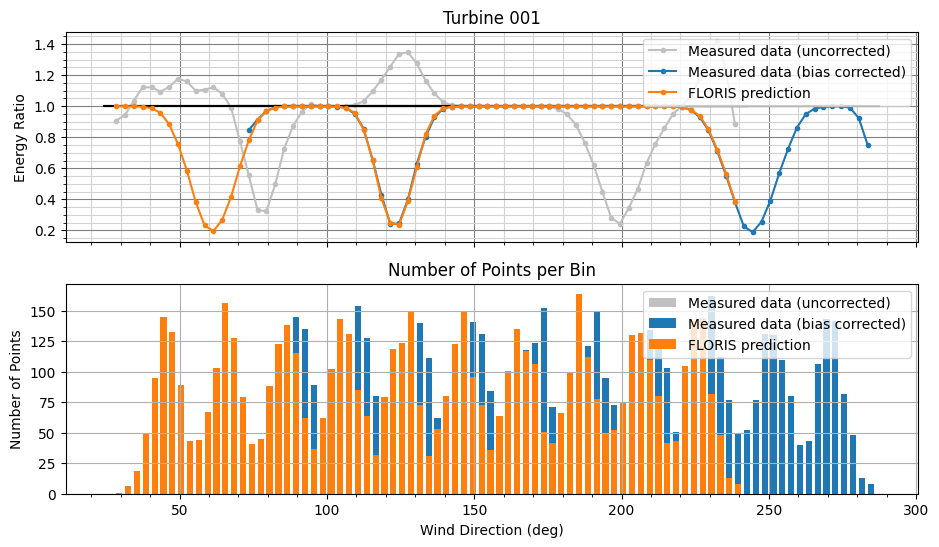

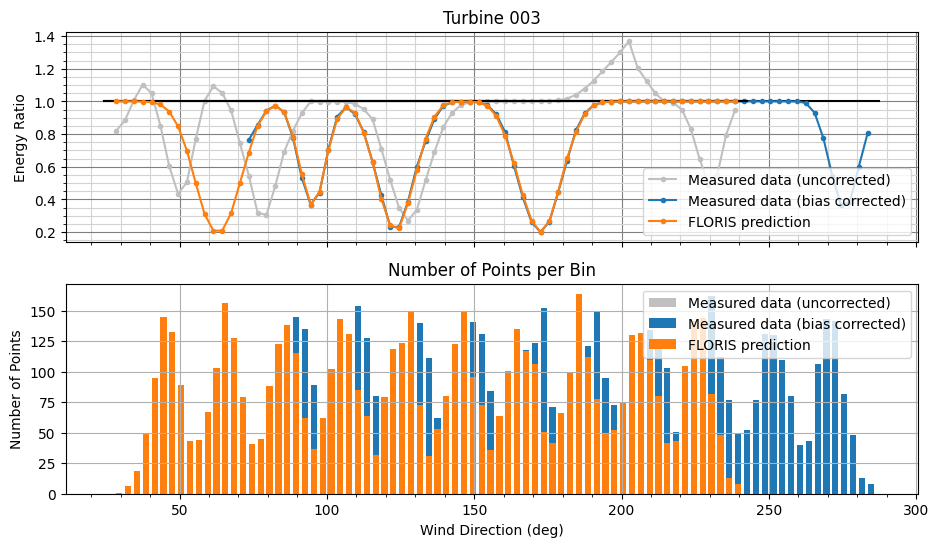

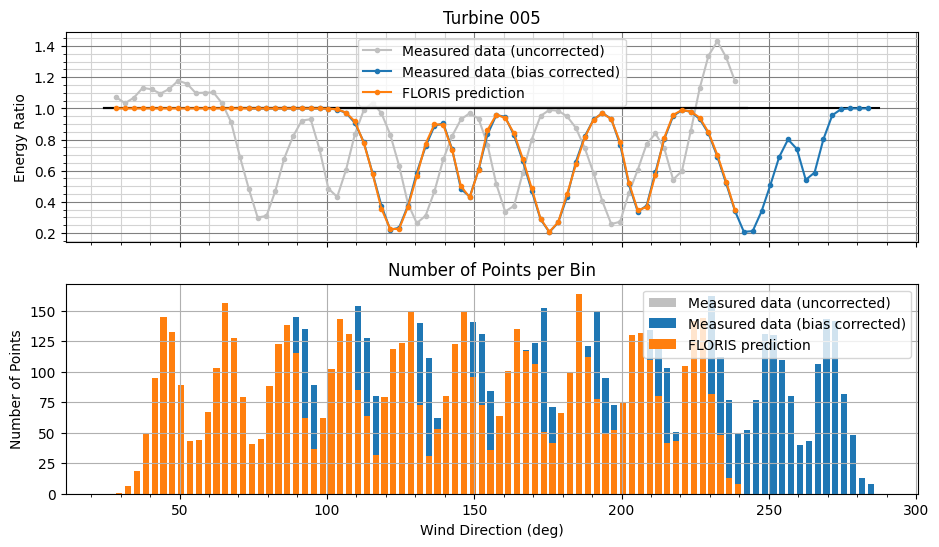

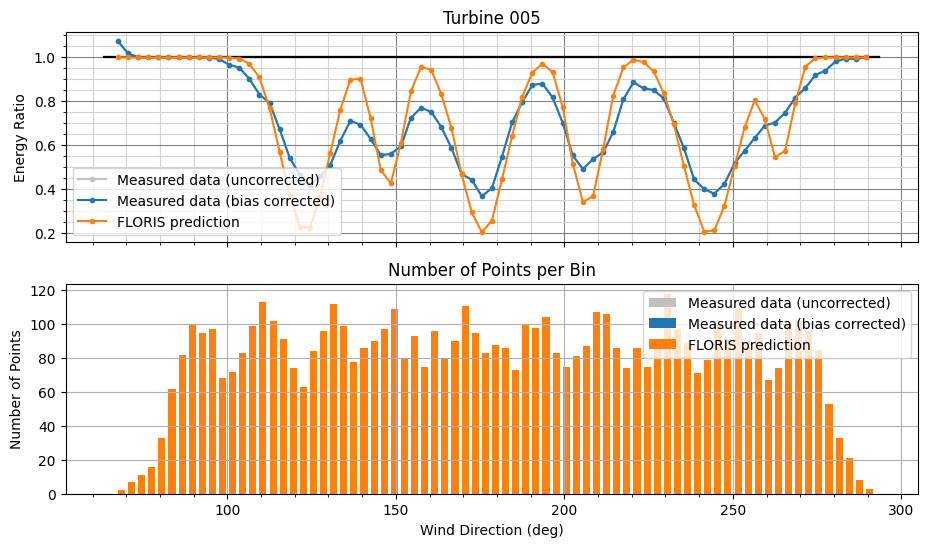

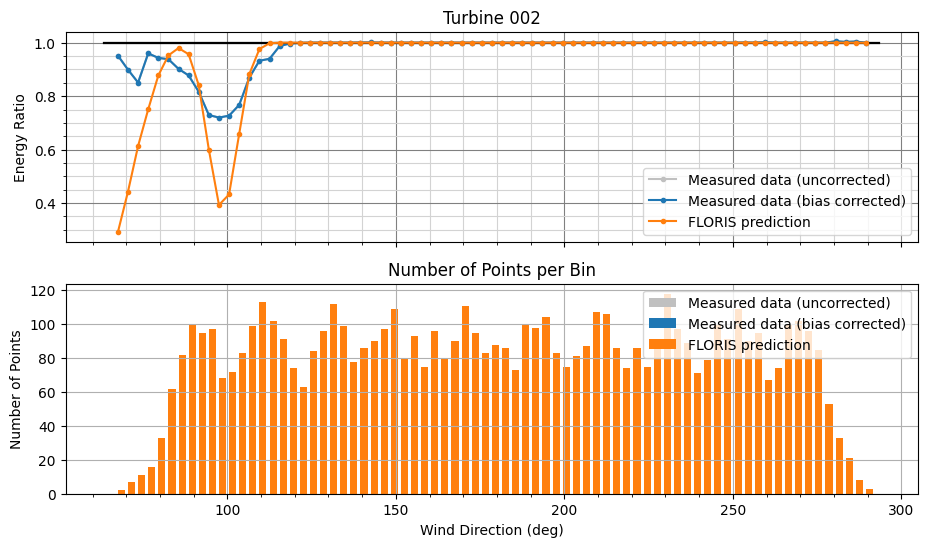

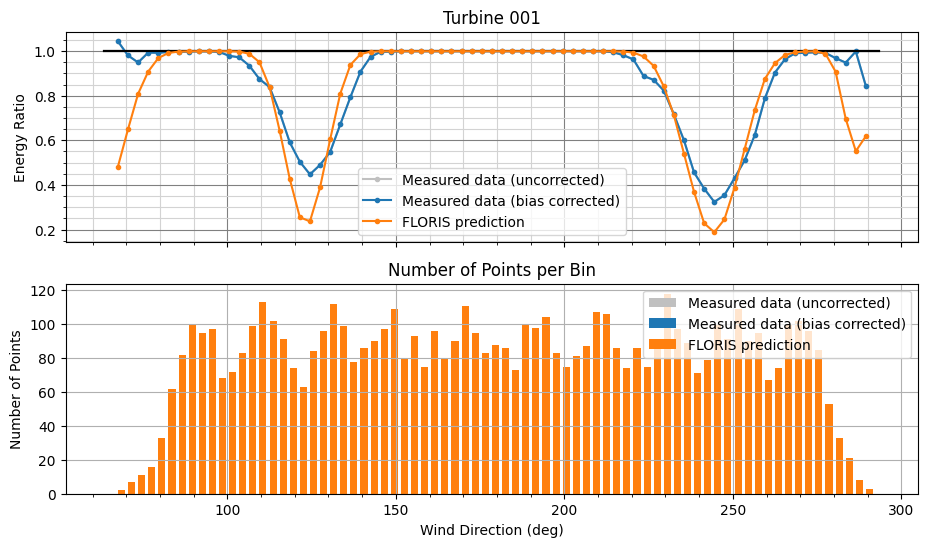

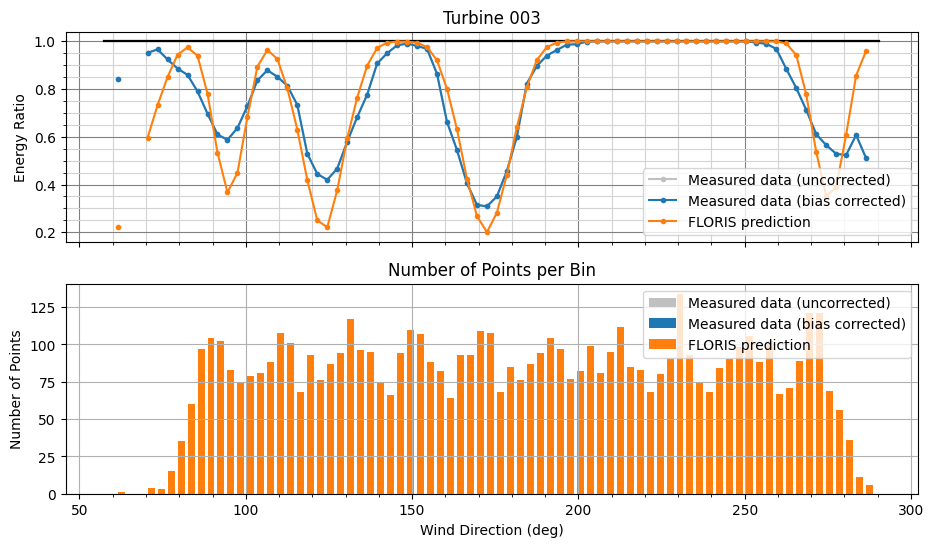

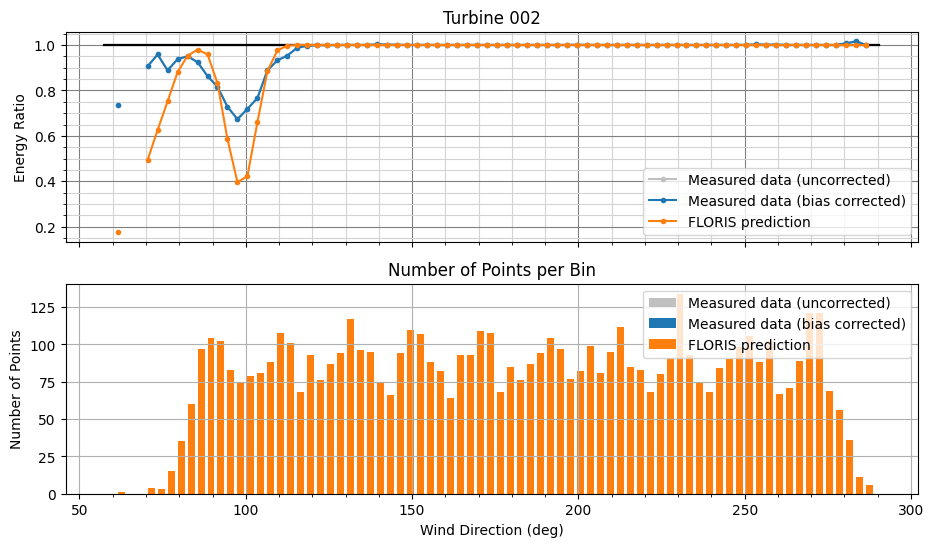

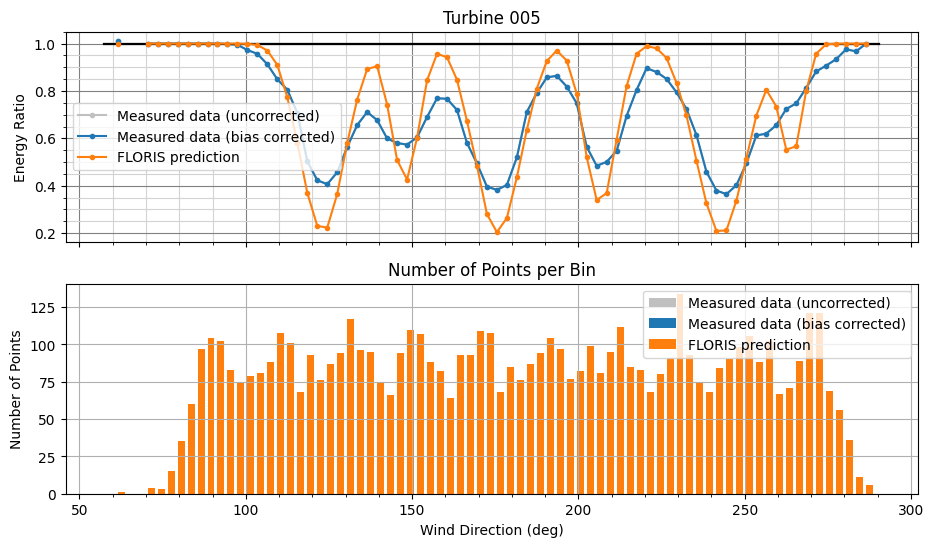

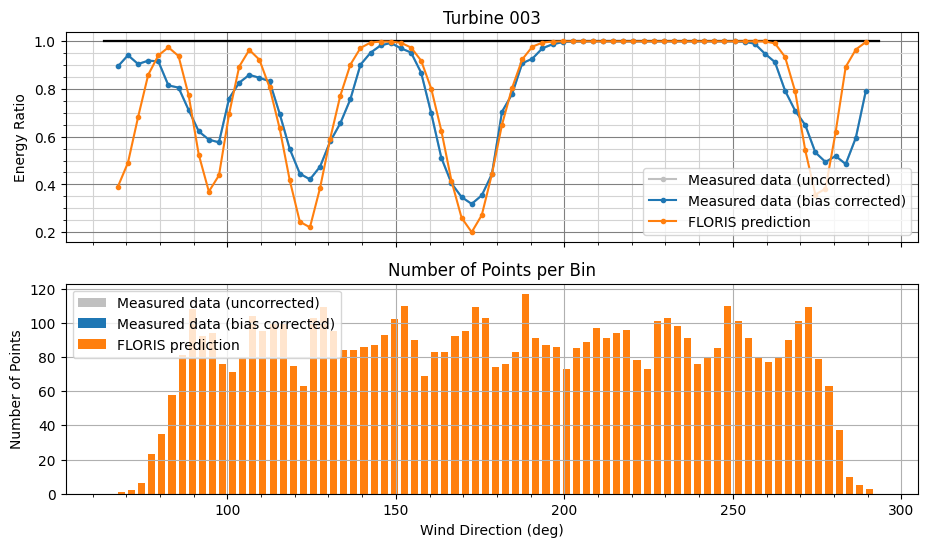

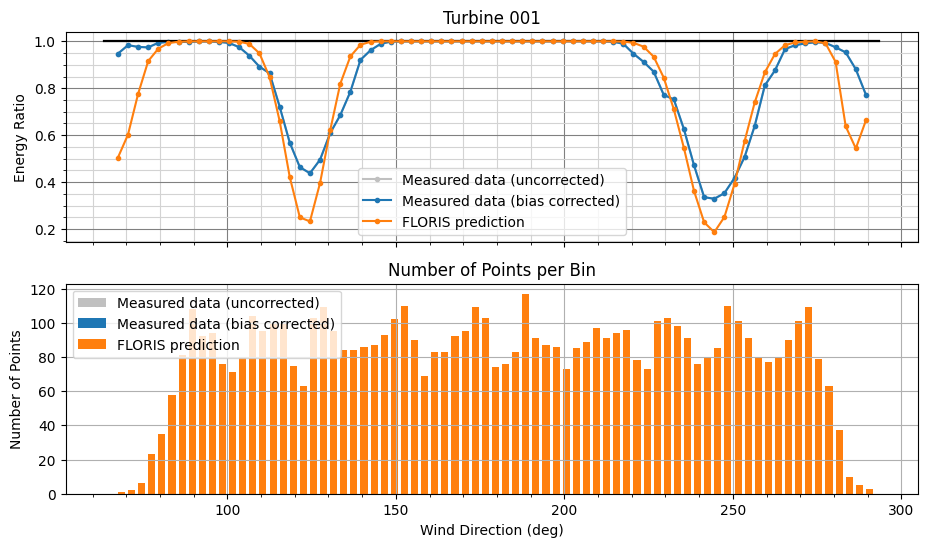

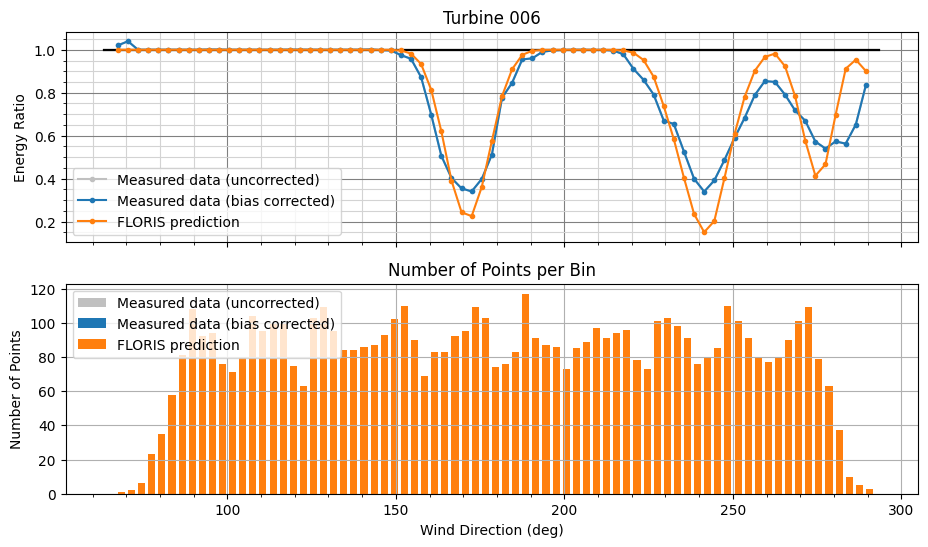

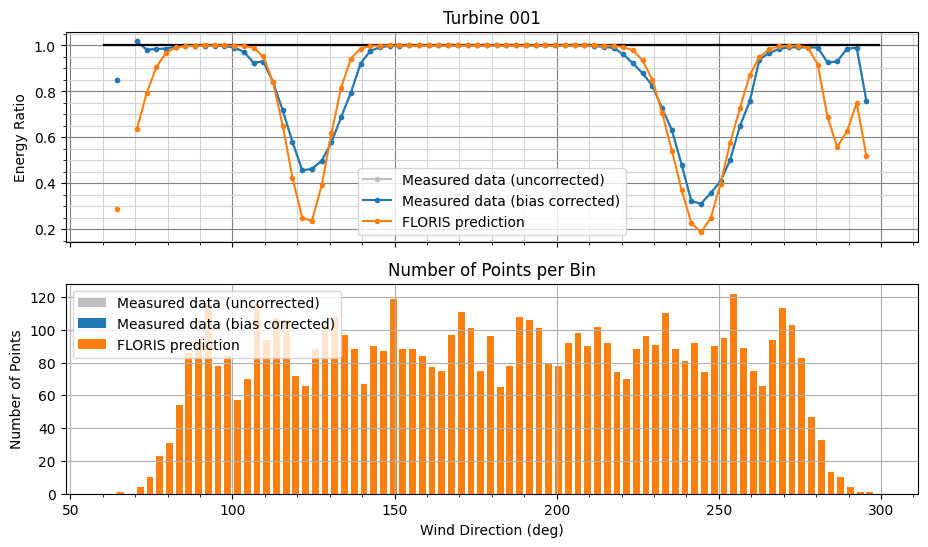

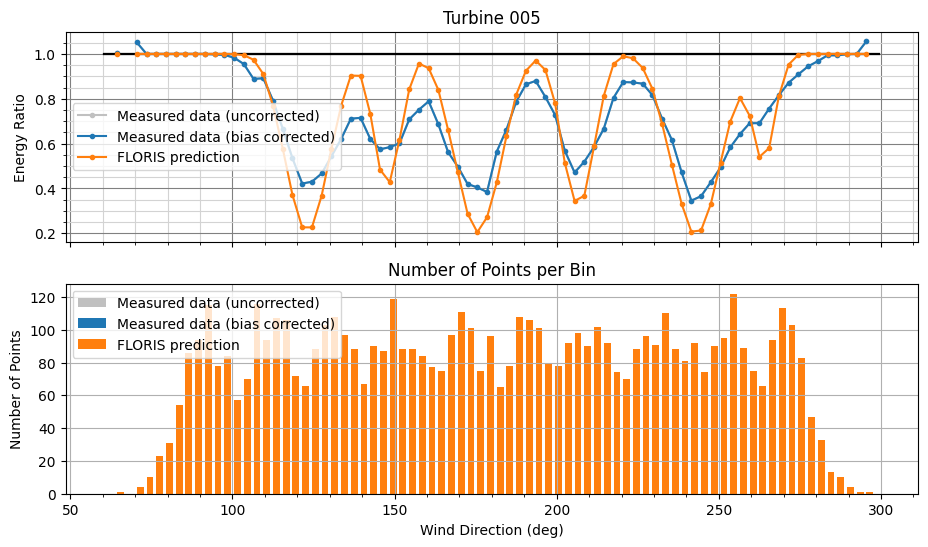

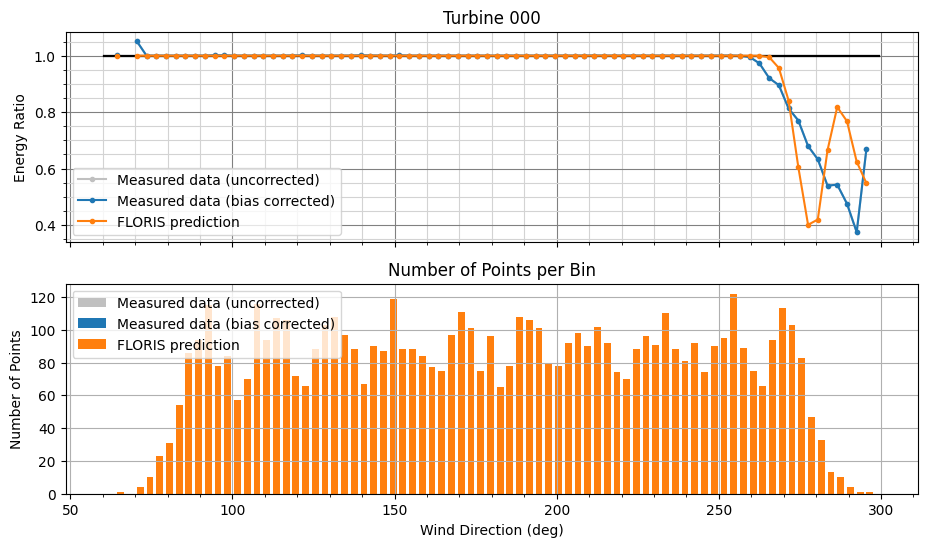

In [17]:
def estimate_biases_with_reference_wd(df_scada, fm, wd_ref):
    # Now use this knowledge to estimate bias for every turbine
    num_turbines = len(fm.layout_x)
    wd_bias_list = np.zeros(num_turbines)

    for ti in range(num_turbines):
        # Calculate the offset between this turbine's wind direction and that
        # of the calibrated (reference) wind direction. Note that 'wd_ref' may
        # also be a met mast' wind direction signal, if available. The offset
        # between a turbine's wind direction and wd_ref is very likely to be
        # the bias or close to the bias in this turbine's northing.
        wd_test = df_scada["wd_{:03d}".format(ti)]
        x0, _ = flopt.match_y_curves_by_offset(
            wd_ref, wd_test, dy_eval=np.arange(-180.0, 180.0, 2.0), angle_wrapping=True
        )

        # Then, we refine this first guess by evaluating the cost function
        # at [-5.0, 0.0, 5.0] deg around x0, and let the optimizer
        # converge.
        x_search_bounds = np.round(x0) + np.array([-5.0, 5.0])

        # Calculate and save the results to a list
        wd_bias_list[ti] = get_bias_for_single_turbine(
            df=df_scada,
            fm=fm,
            ti=ti,
            opt_search_range=x_search_bounds,
            plot=True,
            figure_save_path=None,
        )
        print(" ")

    return wd_bias_list


wd_bias_list = estimate_biases_with_reference_wd(df_scada_homogenized, fm, wd_ref)
print("Wind direction biases: {}".format(wd_bias_list))

# **Step 5**: Correct turbine wind directions for bias
The next step is to apply the northing corrections directly on the data.

In [18]:
def apply_bias_corrections(df_scada, wd_bias_list):
    # Copy dataframe
    df_out = df_scada.copy()

    # Load the SCADA data
    num_turbines = dfm.get_num_turbines(df_scada)

    # Set turbine-individual bias corrections
    for ti in range(num_turbines):
        bias = wd_bias_list[ti]
        print("Removing {:.2f} deg bias for ti = {:03d}.".format(bias, ti))
        df_out["wd_{:03d}".format(ti)] = wrap_360(df_out["wd_{:03d}".format(ti)] - bias)

    return df_out


# Get bias corrections
print("wd_bias_list: {}".format(wd_bias_list))
df_scada_homogenized = apply_bias_corrections(
    df_scada=df_scada_homogenized.copy(), wd_bias_list=wd_bias_list
)

wd_bias_list: [ 2.50000e-04  1.49625e+01 -4.49625e+01  0.00000e+00  0.00000e+00
  0.00000e+00  2.50000e-04]
Removing 0.00 deg bias for ti = 000.
Removing 14.96 deg bias for ti = 001.
Removing -44.96 deg bias for ti = 002.
Removing 0.00 deg bias for ti = 003.
Removing 0.00 deg bias for ti = 004.
Removing 0.00 deg bias for ti = 005.
Removing 0.00 deg bias for ti = 006.


# **Step 6**: Deal with inter-turbine faults
Deal with faults at one turbine causing issues at another turbine. For example, if a turbine is shedding a wake on a second turbine, then for a fair comparison both of these two turbines should be operating normally. If the upstream turbine is curtailed or offline, the power production of the downstream turbine also changes. Hence, if we are unsure about the operating mode of one machine, we cannot make accurate FLORIS predictions on the second turbine either. In this scenario, we would classify the second turbine's measurement as faulty too, because of this.

In [19]:
def filter_for_faults_in_impacting_turbines(df):
    # Determine which turbines impact which other turbines through their wakes
    print("Calculating the 'df_impacting_turbines' matrix...")
    df_impacting_turbines = ftools.get_all_impacting_turbines(
        fm_in=fm,
        wd_array=np.arange(0.0, 360.0, 3.0),
        change_threshold=0.005,
        ws_test=9.0,
    )
    print(df_impacting_turbines)

    # Filter the measurements for each turbine: make sure all
    # other turbines affecting this turbine's
    # power production are marked as good measurements. If they are not,
    # then classify this turbine's
    # measurement as faulty too.
    num_turbines = dfm.get_num_turbines(df)
    for ti in range(num_turbines):
        # Assign a reference wind direction for this turbine. In this case,
        # we have such a small farm so we assume that the farm average wind
        # direction of representative of every turbine.
        df = dfm.set_wd_by_all_turbines(df)

        df_scada = filt.filter_df_by_faulty_impacting_turbines(
            df=df,
            ti=ti,
            df_impacting_turbines=df_impacting_turbines,
            verbose=True,
        )

    return df_scada


df_scada_northing_calibrated_interturbine_filtered = filter_for_faults_in_impacting_turbines(
    df=df_scada_homogenized.copy()
)

floris.floris_model.FlorisModel WARNING Deleting stored wind_data information.


Calculating the 'df_impacting_turbines' matrix...


floris.floris_model.FlorisModel WARNING Deleting stored wind_data information.
floris.floris_model.FlorisModel WARNING Deleting stored wind_data information.
floris.floris_model.FlorisModel WARNING Deleting stored wind_data information.
floris.floris_model.FlorisModel WARNING Deleting stored wind_data information.
floris.floris_model.FlorisModel WARNING Deleting stored wind_data information.
floris.floris_model.FlorisModel WARNING Deleting stored wind_data information.
2024-12-02 11:23:51 Faulty measurements for WTG 00 increased from 0.000 % to 0.000 %. Reason: 'Turbine is impacted by faulty upstream turbine'.
2024-12-02 11:23:51 Faulty measurements for WTG 01 increased from 0.000 % to 0.000 %. Reason: 'Turbine is impacted by faulty upstream turbine'.
2024-12-02 11:23:51 Faulty measurements for WTG 02 increased from 0.000 % to 0.000 %. Reason: 'Turbine is impacted by faulty upstream turbine'.
2024-12-02 11:23:51 Faulty measurements for WTG 03 increased from 0.000 % to 0.000 %. Reason: 

            0    1       2   3   4   5   6
wd                                        
0.0       [6]  [5]     [3]  []  []  []  []
3.0       [6]  [5]     [3]  []  []  []  []
6.0       [6]  [5]     [3]  []  []  []  []
9.0       [6]  [5]     [3]  []  []  []  []
12.0       []  [5]     [3]  []  []  []  []
...       ...  ...     ...  ..  ..  ..  ..
345.0  [6, 5]  [5]     [3]  []  []  []  []
348.0  [6, 5]  [5]  [3, 5]  []  []  []  []
351.0     [6]  [5]     [3]  []  []  []  []
354.0     [6]  [5]     [3]  []  []  []  []
357.0     [6]  [5]  [3, 5]  []  []  []  []

[120 rows x 7 columns]


# Show the final yaw angles

Text(0, 0.5, 'Wind direction (deg)')

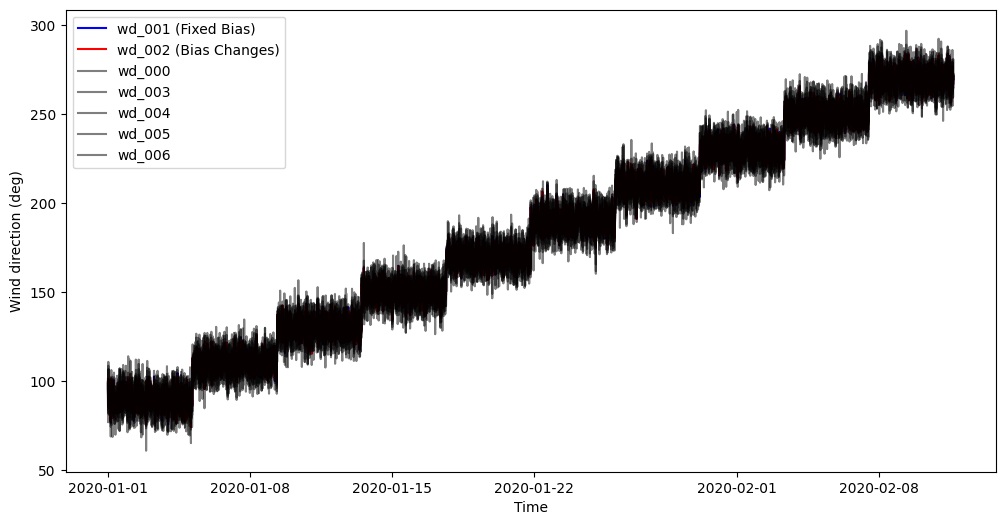

In [ ]:
# Show the effects of homogenization
# Show the wd channels for the turbines
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(
    df_scada_homogenized["time"],
    df_scada_homogenized["wd_001"],
    label="wd_001 (Fixed Bias)",
    color="blue",
)
ax.plot(
    df_scada_homogenized["time"],
    df_scada_homogenized["wd_002"],
    label="wd_002 (Bias Changes)",
    color="red",
)
ax.plot(
    df_scada_homogenized["time"],
    df_scada_homogenized["wd_000"],
    label="wd_000",
    color="k",
    alpha=0.5,
)
ax.plot(
    df_scada_homogenized["time"],
    df_scada_homogenized["wd_003"],
    label="wd_003",
    color="k",
    alpha=0.5,
)
ax.plot(
    df_scada_homogenized["time"],
    df_scada_homogenized["wd_004"],
    label="wd_004",
    color="k",
    alpha=0.5,
)
ax.plot(
    df_scada_homogenized["time"],
    df_scada_homogenized["wd_005"],
    label="wd_005",
    color="k",
    alpha=0.5,
)
ax.plot(
    df_scada_homogenized["time"],
    df_scada_homogenized["wd_006"],
    label="wd_006",
    color="k",
    alpha=0.5,
)
ax.legend()
ax.set_xlabel("Time")
ax.set_ylabel("Wind direction (deg)")